**DQN_Village_Agent_Game_3_Crops**

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler


In [3]:
# use variables CORN , BEAN , COTTON 
def get_data(period):
     # returns a T x 3 list of market prices
     # each row is a different step 
     # 0 = Hold
     # 1 = Plant
     # 2 = Sell
    df=pd.DataFrame(columns=["CORN","BEAN","COTTON"])

    corn_base_price = 20.0
    bean_base_price = 25.0
    cotton_base_price = 30.0
    df["CORN"] =np.random.normal(60.0, 20.0, period)
    df["BEAN"] =np.random.normal(70.0, 25.0, period)
    df["COTTON"] =np.random.normal(100.0, 30.0, period)    
    df["CORN"].where(df["CORN"]<=corn_base_price, corn_base_price)
    df['BEAN'].where(df['BEAN']<=bean_base_price, bean_base_price)
    df['COTTON'].where(df['COTTON']<=cotton_base_price, cotton_base_price)   
    return df.values

In [4]:
def get_scaler(env):
# return scikit-learn scaler object to scale the states
# Note: you could also populate the replay buffer here
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
#         print(action)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
#     print("===============states (statem reward, done, info)=========================")
#     for c in states:
#         print(c)    
    scaler = StandardScaler()
    scaler.fit(states)     
    return scaler 

In [5]:
# to store trained model with result
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


In [6]:
class DQLModel:
    """ Neural Network Model with Stochastic Gradient Descent """
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []
    
    #Predict function to predict the state Q value
    def predict(self, X):
        # make sure X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b
    
    #Stochastic Gradient Descent
    def sgd(self, X, Y, learning_rate=0.0001, momentum=0.99):
        # make sure dimension of X is N x D
        assert(len(X.shape) == 2)

        # the loss values are 2-D
        # normally we would divide by N only
        # but now we divide by N x K
        num_values = np.prod(Y.shape)    
        
        # do one step of gradient descent
        # we multiply by 2 to get the exact gradient
        # (not adjusting the learning rate)
        # i.e. d/dx (x^2) --> 2x
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values          
        
        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb       
        

        # update params
        self.W += self.vW
        self.b += self.vb

#         print("weight : ", self.W)       
        
        mse = np.mean((Yhat - Y)**2)        
        self.losses.append(mse)
        
        return mse
    
    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)


In [7]:
class VillageEnv:
    """
    A 3-item village gaming environment.
    𝑠𝑡𝑎𝑡𝑒  = ["𝑚𝑜𝑛𝑒𝑦_𝑣𝑎𝑙𝑢𝑒", "𝑙𝑎𝑏𝑜𝑟_𝑢𝑛𝑖𝑡𝑠", "𝑐𝑜𝑟𝑛_𝑝𝑟𝑖𝑐𝑒", "𝑏𝑒𝑎𝑛_𝑝𝑟𝑖𝑐𝑒", "𝑐𝑜𝑡𝑡𝑜𝑛_𝑝𝑟𝑖𝑐𝑒", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝐶𝑜𝑟𝑛_𝑤𝑒𝑒𝑘1", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑟n_𝑤𝑒𝑒𝑘2", 
              "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑟𝑛_𝑤𝑒𝑒𝑘_3", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘1", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘2", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘3", "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘1",   
              "𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘2","𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘3", "𝑠𝑡𝑜𝑟𝑒𝑑_𝑐𝑜𝑟𝑛", "𝑠𝑡𝑜𝑟𝑒𝑑_𝑏𝑒𝑎𝑛", "𝑠𝑡𝑜𝑟𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛"]

    State: vector of size 17 (n_item * 5 + 2)
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝐶𝑜𝑟𝑛_𝑤𝑒𝑒𝑘1 - planted corn of 1 week old 
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑟n_𝑤𝑒𝑒𝑘2 - planted corn of 2 week old
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑟n_𝑤𝑒𝑒𝑘3 - planted corn of 3 week old, which is ready for harvest and stored in barn
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘1 - planted 𝑏𝑒𝑎𝑛 of 1 week old 
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘2 - planted 𝑏𝑒𝑎𝑛 of 2 week old
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑏𝑒𝑎𝑛_𝑤𝑒𝑒𝑘3 - planted 𝑏𝑒𝑎𝑛 of 3 week old, which is ready for harvest and stored in barn
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘1 - planted 𝑏𝑒𝑎𝑛 of 1 week old 
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘2 - planted 𝑏𝑒𝑎𝑛 of 2 week old
        - # 𝑝𝑙𝑎𝑛𝑡𝑒𝑑_𝑐𝑜𝑡𝑡𝑒𝑛_𝑤𝑒𝑒𝑘3 - planted 𝑏𝑒𝑎𝑛 of 3 week old, which is ready for harvest and stored in barn    
        - # shares of stock 2 owned
        - # shares of stock 3 owned
        - price of stock 1 (using daily close price)
        - 𝑐𝑜𝑟𝑛_𝑝𝑟𝑖𝑐𝑒 price of corn 
        - 𝑏𝑒𝑎𝑛_𝑝𝑟𝑖𝑐𝑒 price of bean 
        - 𝑐𝑜𝑡𝑡𝑜𝑛_𝑝𝑟𝑖𝑐𝑒 price of cotton
        - Money Value (can be used to purchase more labor units and pay the family expenses)
        - 𝑙𝑎𝑏𝑜𝑟_𝑢𝑛𝑖𝑡𝑠 (can be used to plant & harves crops)
    Action: categorical variable with 27 (3^3) possibilities
        - for each stock, you can:
        - 0 = sell
        - 1 = hold
        - 2 = plant
    """
    def __init__(self, data, initial_investment=1000, initial_labor_unit=52):
        # data
        self.market_price_time_series = data
        self.n_step, self.n_crop = self.market_price_time_series.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.initial_labor_unit = initial_labor_unit
        self.cur_step = None
        self.crop_in_barn = None
        self.crop_planted_week1 = None
        self.crop_planted_week2 = None
        self.crop_planted_week3 = None   
        self.market_price = None
        self.cash_in_hand = None
        self.labor_in_hand = None


        self.action_space = np.arange(3**self.n_crop)
        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = plant
        
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_crop)))

        # calculate size of state
        self.state_dim = self.n_crop * 5 + 2

        self.reset()
    
    def reset(self):
        self.cur_step = 0
        self.crop_planted_week1 = np.zeros(self.n_crop)
        self.crop_planted_week2 = np.zeros(self.n_crop)
        self.crop_planted_week3 = np.zeros(self.n_crop)    
        self.crop_in_barn = np.zeros(self.n_crop)        
        self.market_price = self.market_price_time_series[self.cur_step]
        self.cash_in_hand = self.initial_investment
        self.labor_in_hand = self.initial_labor_unit

        return self._get_obs()
    
    def _get_obs(self):        
        obs                              = np.empty(self.state_dim)
        obs[:self.n_crop]                = self.crop_planted_week1
        obs[self.n_crop:2*self.n_crop]   = self.crop_planted_week2
        obs[2*self.n_crop:3*self.n_crop] = self.crop_planted_week3
        obs[3*self.n_crop:4*self.n_crop] = self.crop_in_barn
        obs[4*self.n_crop:5*self.n_crop] = self.market_price        
        obs[-2] = self.labor_in_hand
        obs[-1] = self.cash_in_hand
#         print(obs)
#         print("planted week 1",self.crop_planted_week1)
#         print("planted week 2",self.crop_planted_week2)
#         print("planted week 3",self.crop_planted_week3)
#         print("crop_in_barn",self.crop_in_barn)
#         print("market_price",self.market_price)
#         print("labor_in_hand",self.labor_in_hand)
#         print("cash_in_hand",self.cash_in_hand)
        return obs
    
    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()
#         print("Action...:", action,"    prev_val...", prev_val)

        # update price, i.e. go to the next day
        self.cur_step += 1        
        self.market_price = self.market_price_time_series[self.cur_step]
        
        # perform the action
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have reached out the end of the time series step or money value is zero
        done = (self.cur_step == self.n_step - 1)|(self.cash_in_hand < 0)

        # store the current value of the portfolio here
        info = {'cur_val': cur_val, 'cash_in_hand': self.cash_in_hand}
        
#         print("done", done)
        # conform to the Gym API
        return self._get_obs(), reward, done, info
    
    #Get the q value of the state
    def _get_val(self):
        self.planted_crop_value = [20.0,25.0,30]        
        wealth = (self.crop_planted_week1.dot(self.planted_crop_value) + 
                 self.crop_planted_week2.dot(self.planted_crop_value) +
                 self.crop_planted_week3.dot(self.planted_crop_value) +
                 self.crop_in_barn.dot(self.market_price) + self.cash_in_hand)        
        return wealth
    
    # perform the action
    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = plant
        # e.g. [2,1,0] means:
        # plant first crop, hold second crop, and sell third crop - 1st crop :corn; 2nd crop: bean; 3rd crop: cotton 
        # hold second stock
        # sell third stock
        self.money_val_toplant = [25,55,30]
        action_vec = self.action_list[action]
       
        # determine which stocks to buy or sell
        sell_index = [] # stores index of crops we want to sell
        plant_index = [] # stores index of crops we want to plant
        
        self.cash_in_hand -= 25    #Weekly expense for family
        # weekly family expenses
        self.crop_in_barn +=  self.crop_planted_week3
        self.crop_planted_week3 = self.crop_planted_week2.copy()
        self.crop_planted_week2 = self.crop_planted_week1.copy()
        self.crop_planted_week1[:] = 0
#         print("###########################################################")
#         print("cash in hand:",self.cash_in_hand,"  barn:",self.crop_in_barn, "labor: ",self.labor_in_hand)       
#         print("planted week 3:", self.crop_planted_week3)
#         print("planted week 2:", self.crop_planted_week2)
#         print("planted week 1:", self.crop_planted_week1)
           
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                plant_index.append(i)
        # sell any crop we want to sell at the current market price
        # then plant any crop we want to plant
        if sell_index:
          # NOTE: to simplify the problem, when we sell, we will sell ALL stocks of that crop
          for i in sell_index: 
            self.cash_in_hand += self.market_price[i] * self.crop_in_barn[i]
            self.crop_in_barn[i] = 0            
        if plant_index:
            # NOTE: when buying, we will loop through each crop we want to buy,
            # and buy one crop at a time until we run out of cash
            can_plant = True
            unit_to_plant = 3
            while can_plant:
                for i in plant_index:
#                     print("Plant action", i)
                    if unit_to_plant > 0:
                        if self.labor_in_hand > 0:
                            self.crop_planted_week1[i] += 1 # plant one crop
                            self.labor_in_hand -= 25
                            unit_to_plant -=1
                        elif self.cash_in_hand > self.money_val_toplant[i]:
                            self.crop_planted_week1[i] += 1 # plant one crop
                            self.cash_in_hand -= self.money_val_toplant[i]
                            unit_to_plant -=1
                    else:
                        can_plant = False


In [8]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQLModel(state_size, action_size)
    
    def act(self, state):        
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
#         print("epsilon",self.epsilon)
#         print("predicted", act_values)
#         print("predicted: ", np.argmax(act_values[0]))
        return np.argmax(act_values[0])  # returns action
    
    #train the network using back probagation & SGD optimizer with momentum term 
    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.argmax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target
        
        
#         print("target_full:", target_full)

        # Run one training step
        error = self.model.sgd(state, target_full)       
        
        
#         print("  action: ",action, "  reward:", reward,  " error: ", error)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    
    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)


In [9]:
def play_one_episode(agent, env, is_train):
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val'], info['cash_in_hand']

In [10]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(x, xlabel, ylabel, title):
    # matplotlib histogram
    plt.hist(x, color = 'blue', edgecolor = 'black',
             bins = 10)

    # seaborn histogram
    sns.distplot(x, hist=True, kde=False, 
                 bins=10, color = 'blue',
                 hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Sate size 17, Action Size 27
episode: 100/10000, value: 2854.81, cash: 864.98, max_cash: 2735.99 duration: 0:00:00.001994
episode: 200/10000, value: 2969.92, cash: 280.00, max_cash: 2735.99 duration: 0:00:00.002986
episode: 300/10000, value: 2984.92, cash: 265.00, max_cash: 2735.99 duration: 0:00:00.001997
episode: 400/10000, value: 2974.92, cash: 275.00, max_cash: 2735.99 duration: 0:00:00.001995
episode: 500/10000, value: 2764.23, cash: 677.48, max_cash: 2735.99 duration: 0:00:00.002992
episode: 600/10000, value: 2940.16, cash: 275.00, max_cash: 2735.99 duration: 0:00:00.002996
episode: 700/10000, value: 2984.92, cash: 355.00, max_cash: 2735.99 duration: 0:00:00.002992
episode: 800/10000, value: 2351.67, cash: 1670.63, max_cash: 2735.99 duration: 0:00:00.004023
episode: 900/10000, value: 3004.68, cash: 280.00, max_cash: 2735.99 duration: 0:00:00.003990
episode: 1000/10000, value: 3079.21, cash: 275.00, max_cash: 2735.99 duration: 0:00:00.002993
episode: 1100/10000, value: 3074.21, ca

episode: 8800/10000, value: 3213.26, cash: 280.00, max_cash: 2949.21 duration: 0:00:00.002990
episode: 8900/10000, value: 3218.26, cash: 275.00, max_cash: 2949.21 duration: 0:00:00.002992
episode: 9000/10000, value: 3099.11, cash: 553.05, max_cash: 2949.21 duration: 0:00:00.002990
episode: 9100/10000, value: 3138.26, cash: 190.00, max_cash: 2949.21 duration: 0:00:00.002508
episode: 9200/10000, value: 3145.19, cash: 529.61, max_cash: 2949.21 duration: 0:00:00.002989
episode: 9300/10000, value: 3138.67, cash: 523.09, max_cash: 2949.21 duration: 0:00:00.002991
episode: 9400/10000, value: 3183.49, cash: 275.00, max_cash: 2949.21 duration: 0:00:00.003025
episode: 9500/10000, value: 3148.73, cash: 275.00, max_cash: 2949.21 duration: 0:00:00.004995
episode: 9600/10000, value: 3183.49, cash: 275.00, max_cash: 2949.21 duration: 0:00:00.002994
episode: 9700/10000, value: 2575.88, cash: 1211.43, max_cash: 3008.67 duration: 0:00:00.002991
episode: 9800/10000, value: 3156.93, cash: 459.43, max_cash

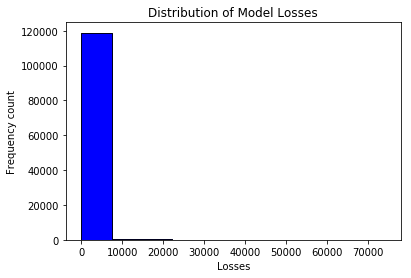

In [11]:
if __name__ == '__main__':
    
    # configuration
    np.random.seed(seed=12)
    models_folder = 'DQN_Village_Agent_models'
    rewards_folder = 'DQN_Village_Agent_rewards'
    num_episodes = 10000    
    batch_size = 32
    initial_investment = 1000
    initial_labor_unit = 500
    mode = 'train'
    number_of_weeks = 13

    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)
    data = get_data(number_of_weeks*2)
    n_timesteps, n_stocks = data.shape 

    # Create train and test data of market prices
    n_train = n_timesteps // 2
    train_data = data[:n_train]
    test_data = data[n_train:]
    # print("Training Market Price Data Shape",train_data.shape)
    # print("Test Market Price Data Shape",train_data.shape)

    #create environment object
    env = VillageEnv(train_data, initial_investment,initial_labor_unit)
    state_size = env.state_dim
    action_size = len(env.action_space)
    print("Sate size {}, Action Size {}".format(state_size,action_size))


    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    # store the final value of the portfolio (end of episode)
    money_value = []

    if mode == 'test':
        # then load the previous scaler
        with open(f'{models_folder}/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)

        # remake the env with test data
        env = VillageEnv(test_data, initial_investment)

        # make sure epsilon is not 1!
        # no need to run multiple episodes if epsilon = 0, it's deterministic
        agent.epsilon = 0.01

        # load trained weights
        agent.load(f'{models_folder}/linear.npz')

    # play the game num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()
        val, cash = play_one_episode(agent, env, mode)
        dt = datetime.now() - t0
        if (e+1)%100 == 0:
            print(f"episode: {e + 1}/{num_episodes}, value: {val:.2f}, cash: {cash:.2f}, max_cash: {np.max(money_value):.2f} duration: {dt}")
        money_value.append(cash) # append episode end portfolio value


    # save the weights when we are done
    if mode == 'train':
        # save the DQN
        agent.save(f'{models_folder}/linear.npz')

        # save the scaler
        with open(f'{models_folder}/scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)

        # plot losses
    #     plt.plot(agent.model.losses)
        xlabel = "Losses"
        ylabel = "Frequency count"
        title = "Distribution of Model Losses"
        plot_metrics(agent.model.losses, xlabel, ylabel, title)
    #     plt.show()

    # save portfolio value for each episode
    np.save(f'{rewards_folder}/{mode}.npy', money_value)


In [12]:
if mode == 'train':
    print("average train loss: {}".format(round(np.mean(agent.model.losses),3)))
    print("min train loss: {}, max train loss: {}".format(round(np.min(agent.model.losses),3),
                                                          round(np.max(agent.model.losses),3)))

average train loss: 365.645
min train loss: 0.0, max train loss: 74382.14


In [13]:
# agent.model.losses

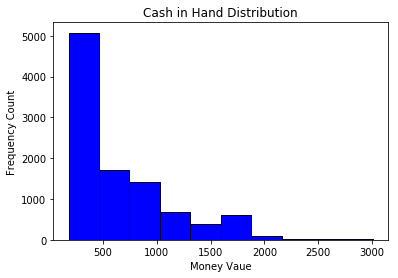

In [14]:
x = money_value
title = 'Cash in Hand Distribution'
xlabel = 'Money Vaue'
ylabel = 'Frequency Count'

plot_metrics(x, xlabel, ylabel, title)

In [15]:
max(money_value)

3008.667003119493

In [16]:
np.mean(money_value)

647.809691577882